# Introduction to LangChain and LangGraph

Maryam Berijanian  
_Last updated: 2025-10-06_



# 1) Setup for Google Colab

**Note: Google Colab Pro is free for students and teachers! Link [here.](https://colab.research.google.com/signup)**

* We are using models from Hugging Face to avoid incurring costs associated with using paid APIs.

* To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as a secret in your Google Colab (using the "🔑" icon in the left panel) with the name `HF_TOKEN`, and restart your session. This secret can then be reused in all of your notebooks.

* Install `transformers`, `accelerate`, `langchain`, `langgraph`, `langchain-huggingface`, `langchain-community`, `sentence-transformers`, and `faiss-cpu`.

* Load a small chat model (**TinyLlama 1.1B Chat**). You can try `Qwen/Qwen2.5-1.5B-Instruct` or `Phi-3-mini-4k-instruct`.

In [ ]:
!pip install -q -U \
  "requests==2.32.4" "numpy==2.0.2" \
  "transformers==4.41.2" "accelerate>=0.29,<1" \
  "langchain>=0.3,<0.4" "langchain-community>=0.3,<0.4" \
  "langgraph==0.2.*" "langchain-huggingface>=0.1,<0.4" \
  "sentence-transformers>=2.6,<3"  "wikipedia" \
  "sentencepiece" "faiss-cpu" "tiktoken" "ipywidgets"


In [ ]:
import os, torch
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from langchain_huggingface import ChatHuggingFace, HuggingFacePipeline
from langchain_core.messages import HumanMessage

MODEL_NAME = os.environ.get("WORKSHOP_MODEL", "TinyLlama/TinyLlama-1.1B-Chat-v1.0")

use_gpu = torch.cuda.is_available()

tok = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
mdl = AutoModelForCausalLM.from_pretrained(MODEL_NAME)

# Common stop markers for chat-tuned HF models with role tokens
STOP_TOKENS = ["</s>", "<|user|>", "<|system|>", "<|assistant|>"]

gen_pipe = pipeline(
    task="text-generation",
    model=mdl,
    tokenizer=tok,
    device=0 if use_gpu else -1,
    do_sample=True,
    temperature=0.3,
    # max_new_tokens=256,
    return_full_text=False,
    eos_token_id=tok.eos_token_id,
    pad_token_id=getattr(tok, "pad_token_id", tok.eos_token_id),
)

# Wrap in LangChain
llm = HuggingFacePipeline(pipeline=gen_pipe)
chat = ChatHuggingFace(llm=llm)

print("Loaded:", MODEL_NAME, "| device:", "GPU" if use_gpu else "CPU")

Loaded: TinyLlama/TinyLlama-1.1B-Chat-v1.0 | device: GPU


# 2) Basic LLM Call  


In [ ]:
resp = chat.invoke(
    [HumanMessage(content="Give me a 2-step plan to make tea.")],
    temperature=0.3,
    max_new_tokens=128,
    do_sample=True,
)
print(resp.content)

Here's a 2-step plan to make tea:

1. Boil water: Start by boiling water in a pot or kettle. You can use a microwave or a stovetop to heat the water.

2. Add tea leaves: Once the water has boiled, add the tea leaves to the pot. You can use loose tea leaves or tea bags.

3. Steep the tea: Allow the tea leaves to steep for the desired amount of time, usually 2-3 minutes.

4. Remove the tea leaves: Once the tea has steeped, remove the tea leaves from the pot.

5. Strain the tea: Pour the tea into a cup or mug and strain the tea leaves using a tea strainer or a cheesecloth.

6. Enjoy: Serve the tea hot or cold, and enjoy the flavor and aroma of your homemade tea!


## LangChain

LangChain is a framework designed to help developers build applications that leverage the power of large language models (LLMs).  
It provides abstractions and components to easily create complex workflows, or "chains," by combining different parts, such as prompts, models, and output parsers. Simple chaining involves connecting these components in a sequence, where the output of one component becomes the input for the next.

## LangChain Expression Language (LCEL)

LangChain Expression Language (LCEL) is a declarative way to compose chains. A key benefit of LCEL is its ability to facilitate the composition of different runnables (components that can be invoked).  
This allows for the creation of sophisticated chains by simply piping components together using the `|` operator. LCEL makes it easy to build complex pipelines with features like streaming, async support, and parallel execution.



In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a concise assistant."),
    ("human", "In one sentence, explain what a collaborative multi-agent system is.")
])
chain = prompt | chat | StrOutputParser()
print(chain.invoke({}))

A collaborative multi-agent system is a network of autonomous agents that work together to achieve a common goal. It involves the coordination and communication of multiple agents to achieve a shared objective, such as solving a complex problem or achieving a specific goal.


# 3) Routing vs Chaining

While basic chaining provides a fixed sequence of steps, more complex applications often require dynamic workflows where the next step depends on the output of the previous one or on some condition. This is where routing comes in.

**Chaining** can be thought of as a linear path: `Step A` (Planner) -> `Step B` (Researcher) -> `Step C` (Writer).

**Routing** allows for conditional paths: After `Step A` (Planner), based on the result, the workflow might go to `Step B` or `Step C` (skip Researcher for trivial tasks).

LangGraph supports **conditional edges**, allowing you to implement routing logic and create workflows with loops and dynamic paths, which is essential for building sophisticated agents and coordinating multiple agents.

**Example: Research Agent**

Here is an example of a research agent; created once using a simple chain, and once using a graph with a conditional edge.  
The result of both agents are the same, as they cannot actually look up the information on the internet!


In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from typing import TypedDict, Optional, Literal
from langgraph.graph import StateGraph, END
import re


def first_n_lines(text: str, n: int) -> str:
    lines = [ln.strip() for ln in (text or "").splitlines() if ln.strip()]
    return "\n".join(lines[:n])

def first_line(text: str) -> str:
    return (text or "").splitlines()[0].strip() if text else ""

In [ ]:
def normalize_plan(raw: str, task: str) -> str:
    """Ensure 1–2 imperative lines, never echoing the task, numbered 1./2."""
    lines = [ln.strip() for ln in (raw or "").splitlines() if ln.strip()]
    flt = [ln for ln in lines if task.lower() not in ln.lower() and "task" not in ln.lower() and "?" not in ln]
    flt = flt[:2]
    cleaned = []
    for i, ln in enumerate(flt, 1):
        ln = re.sub(r"^\s*(\d+\.|[-*•])\s*", "", ln)
        ln = ln.strip()
        cleaned.append(f"{i}. {ln}")
    if not cleaned or any(not re.search(r"^\d\.\s+\w+", ln) for ln in cleaned):
        cleaned = ["1. Search reliable sources", "2. Extract final answer"]
    return "\n".join(cleaned[:2])

def normalize_facts(raw: str) -> str:
    """Return 1–2 short sentences or 'Unknown'."""
    if not raw:
        return "Unknown"
    text = " ".join(
        re.sub(r"^\s*(\d+\.|[-*•])\s*", "", ln.strip())
        for ln in raw.splitlines()
        if ln.strip()
    )
    if text.strip().lower() == "unknown":
        return "Unknown"
    parts = re.split(r'(?<=[.!?])\s+', text)
    sents = [s.strip() for s in parts if s.strip() and s.strip().lower() != "unknown"]
    if not sents:
        return "Unknown"
    # Keep at most 2 sentences, trim any overlong ones, and ensure terminal punctuation.
    out = []
    for s in sents:
        words = s.split()
        if len(words) > 24:  # keep sentences tight
            s = " ".join(words[:24]).rstrip(",;:") + "."
        if not re.search(r'[.!?]$', s):
            s += "."
        out.append(s)
        if len(out) == 2:
            break
    return "\n".join(out) if out else "Unknown"
    # If the model wrote sentences/verbs, keep short nouny spans; else, accept.
    nouny = []
    for ln in lines:
        # cut after ~15 tokens and strip trailing punctuation/verbs cues
        ln = re.sub(r"\b(identify|verify|determine|explain|check|search|look up)\b.*", "", ln, flags=re.I).strip()
        ln = re.sub(r"[.;:]\s*$", "", ln)
        tokens = ln.split()
        ln = " ".join(tokens[:15]).strip()
        if ln:
            nouny.append(ln)
    return "\n".join(nouny[:2]) if nouny else "Unknown"

def normalize_answer(raw: str, facts: str) -> str:
    """Single short phrase (<=15 words), exactly 'unknown' if facts unknown/insufficient."""
    if not facts or facts.strip().lower() == "unknown":
        return "unknown"
    out = first_line(raw)
    out = re.sub(r"^\s*(output|answer|final|result)\s*[:\-]\s*", "", out, flags=re.I)
    out = out.strip().strip('"').strip("'")
    out = " ".join(out.split())
    if not out or out.lower() in {"unknown", "n/a", "not sure"}:
        out = first_line(facts)
    out = " ".join(out.split()[:100]).strip()
    return out if out else "unknown"

In [ ]:
class State(TypedDict):
    task: str
    plan: Optional[str]
    facts: Optional[str]
    draft: Optional[str]
    label: Optional[str]

# Prompts
PlanP = ChatPromptTemplate.from_template(
    "Return ONLY 1–2 numbered imperative steps.\n"
    "Do NOT restate or quote the TASK. No questions.\n\n"
    "TASK:\n{task}\n\n"
    "1."
)

FactsP = ChatPromptTemplate.from_template(
    "Return ONLY 1–2 short sentences with facts needed to answer the TASK.\n"
    "If unknown, write exactly: Unknown\n\n"
    "TASK:\n{task}\n"
    "PLAN:\n{plan}\n\n"
    "-"
)

WriteP = ChatPromptTemplate.from_template(
    "Output ONLY the final answer as a short phrase (not more than 100 words).\n"
    "If facts are Unknown or insufficient, output exactly: unknown\n"
    "No labels, no quotes, no extra words.\n\n"
    "TASK:\n{task}\n"
    "FACTS:\n{facts}\n\n"
)

ClassifyP = ChatPromptTemplate.from_template(
    "Output exactly one token: trivial or research_needed.\n"
    "TASK:\n{task}\n"
    "Label:"
)

In [ ]:
# Nodes
def plan_node(s: State):
    raw = (PlanP | chat | StrOutputParser()).invoke({"task": s["task"]})
    plan = normalize_plan(first_n_lines(raw, 2), s["task"])
    return {**s, "plan": plan}

def research_node(s: State):
    raw = (FactsP | chat | StrOutputParser()).invoke({"task": s["task"], "plan": s.get("plan") or ""})
    facts = normalize_facts(first_n_lines(raw, 2))
    return {**s, "facts": facts}

def write_node(s: State):
    facts = s.get("facts") or "Unknown"
    if facts.strip().lower() == "unknown":
        return {**s, "draft": "unknown"}
    raw = (WriteP | chat | StrOutputParser()).invoke({"task": s["task"], "facts": facts})
    ans = normalize_answer(raw, facts)
    return {**s, "draft": ans}

def classify_node(s: State):
    lab = (ClassifyP | chat | StrOutputParser()).invoke({"task": s["task"]}).strip().lower()
    lab = "trivial" if lab.startswith("trivial") else "research_needed"
    return {**s, "label": lab}

def route_after_plan(s: State) -> Literal["skip","do_research"]:
    return "skip" if (s.get("label") or "research_needed") == "trivial" else "do_research"

In [ ]:
# (planning_node -> research -> write) and the routed graph with classify/conditional edge.

# Pure chain
g_chain = StateGraph(State)
g_chain.add_node("planning_node", plan_node)
g_chain.add_node("research", research_node)
g_chain.add_node("write", write_node)
g_chain.set_entry_point("planning_node")
g_chain.add_edge("planning_node", "research")
g_chain.add_edge("research", "write")
g_chain.add_edge("write", END)
app_chain = g_chain.compile()

In [ ]:
# Routed graph
g_route = StateGraph(State)
g_route.add_node("classify", classify_node)
g_route.add_node("planning_node", plan_node)
g_route.add_node("research", research_node)
g_route.add_node("write", write_node)
g_route.set_entry_point("classify")
g_route.add_edge("classify", "planning_node")
g_route.add_conditional_edges("planning_node", route_after_plan, {"skip": "write", "do_research": "research"})
g_route.add_edge("research", "write")
g_route.add_edge("write", END)
app_route = g_route.compile()

In [ ]:
q = {"task": "What is the current fashion trends?"}

s1 = app_chain.invoke(q)
print("=== CHAIN ===")
print("PLAN:\n", s1.get("plan"))
print("FACTS:\n", s1.get("facts"))
print("DRAFT:\n", s1.get("draft"), "\n")

s2 = app_route.invoke(q)
print("=== ROUTE ===")
print("LABEL:", s2.get("label"))
print("PLAN:\n", s2.get("plan"))
print("FACTS:\n", s2.get("facts"))
print("DRAFT:\n", s2.get("draft"))

=== CHAIN ===
PLAN:
 1. Search reliable sources
2. Extract final answer
FACTS:
 Sure, here's a plan for answering the TASK: Search reliable sources:.
DRAFT:
 Here's the final answer as a short phrase (not more than 100 words) for the TASK: 

=== ROUTE ===
LABEL: research_needed
PLAN:
 1. Answer: The current fashion trends are trendy and popular among people.
FACTS:
 TASK: What is the current fashion trends in the fashion industry?
DRAFT:
 TASK: What is the current fashion trends in the fashion industry?


# 4) Tool Use

[Tools](https://python.langchain.com/docs/concepts/tools/) are external functions or services that agents can [call](https://python.langchain.com/docs/concepts/tool_calling/) (e.g., calculators, search APIs, databases). They extend LLMs beyond text generation, enabling actions like calculations, fetching real-time info, or API integration.

### Creating Tools

Use the `@tool` decorator to turn Python functions into LangChain-compatible tools. The decorator infers name, description, and arguments automatically.

[Model Context Protocol (MCP) servers](https://github.com/langchain-ai/langchain-mcp-adapters) can also serve as tools.

### How They Work

Tools are made available to models through binding. With function-calling–capable models, tools can be bound directly using `bind_tools`.

When a tool is bound to the model, the model can choose to call the tool by returning a structured output with tool arguments. We use the `bind_tools` method to augment an LLM with tools.

For other models, agents (like `AgentExecutor` or LangGraph-based agents) handle tool invocation logic.

### Tool Invocation

LLMs can call tools by returning structured outputs with arguments. You can control tool use:

  * [`tool_choice`](https://python.langchain.com/docs/how_to/tool_choice/) parameter → enforce or restrict tool calls (`any`, specific, etc.).
  * [`parallel_tool_calls=False`](https://python.langchain.com/docs/how_to/tool_calling_parallel/) → limit to one tool call at a time.


### Demo

For this basic demonstration, we'll simulate a simple flow where the model *could* use the tool if it understood. The current setup with a simple chain might not automatically invoke the tool.

A full agent framework (like LangGraph agents) is needed for the model to dynamically decide to call the tool and process its output.

Although this direct binding might not trigger tool use with all models/setups in a simple chain, it conceptually shows how tools are made available to the model within LangChain runnables.

In [ ]:
import requests
import datetime as dt
from pydantic import BaseModel, Field
from langchain.agents import tool


class OpenMeteoInput(BaseModel):
    latitude: float = Field(..., description="Latitude of the location to fetch weather data for")
    longitude: float = Field(..., description="Longitude of the location to fetch weather data for")


@tool(args_schema=OpenMeteoInput)
def get_current_temperature(latitude: float, longitude: float) -> str:
    """Fetch current temperature for given coordinates."""
    BASE_URL = "https://api.open-meteo.com/v1/forecast"
    params = {
        "latitude": latitude,
        "longitude": longitude,
        "hourly": "temperature_2m",
        "forecast_days": 1,
        "timezone": "UTC",
    }

    def _parse_utc(ts: str) -> dt.datetime:
      if ts.endswith("Z"):
          return dt.datetime.fromisoformat(ts.replace("Z", "+00:00"))
      d = dt.datetime.fromisoformat(ts)
      return d.replace(tzinfo=dt.timezone.utc) if d.tzinfo is None else d.astimezone(dt.timezone.utc)

    r = requests.get(BASE_URL, params=params, timeout=20)
    if r.status_code != 200:
        raise RuntimeError(f"API request failed: {r.status_code} {r.text[:200]}")
    data = r.json()

    now_utc = dt.datetime.now(dt.timezone.utc)
    times = [_parse_utc(t) for t in data["hourly"]["time"]]
    temps = data["hourly"]["temperature_2m"]

    idx = min(range(len(times)), key=lambda i: abs(times[i] - now_utc))
    temp_c = temps[idx]
    when = times[idx].isoformat()

    return f"The current temperature near ({latitude:.3f}, {longitude:.3f}) is {temp_c}°C (closest hour: {when})."

In [ ]:
from langchain_core.utils.function_calling import convert_to_openai_function

print(convert_to_openai_function(get_current_temperature))
print(get_current_temperature.invoke({"latitude": 13, "longitude": 14}))

{'name': 'get_current_temperature', 'description': 'Fetch current temperature for given coordinates.', 'parameters': {'properties': {'latitude': {'description': 'Latitude of the location to fetch weather data for', 'type': 'number'}, 'longitude': {'description': 'Longitude of the location to fetch weather data for', 'type': 'number'}}, 'required': ['latitude', 'longitude'], 'type': 'object'}}
The current temperature near (13.000, 14.000) is 24.3°C (closest hour: 2025-10-07T04:00:00+00:00).


In [ ]:
import wikipedia

@tool
def search_wikipedia(query: str) -> str:
    """Run Wikipedia search and get page summaries."""
    titles = wikipedia.search(query) or []
    summaries = []
    for title in titles[:3]:
        try:
            page = wikipedia.page(title=title, auto_suggest=False)
            summaries.append(f"Page: {title}\nSummary: {page.summary}")
        except (wikipedia.exceptions.PageError, wikipedia.exceptions.DisambiguationError):
            continue
    return "\n\n".join(summaries) if summaries else "No good Wikipedia Search Result was found"

print(convert_to_openai_function(search_wikipedia))
print(search_wikipedia.invoke("langchain"))

{'name': 'search_wikipedia', 'description': 'Run Wikipedia search and get page summaries.', 'parameters': {'properties': {'query': {'type': 'string'}}, 'required': ['query'], 'type': 'object'}}
Page: LangChain
Summary: LangChain is a software framework that helps facilitate the integration of large language models (LLMs) into applications. As a language model integration framework, LangChain's use-cases largely overlap with those of language models in general, including document analysis and summarization, chatbots, and code analysis.

Page: Vector database
Summary: A vector database, vector store or vector search engine is a database that uses the vector space model to store vectors (fixed-length lists of numbers) along with other data items. Vector databases typically implement one or more approximate nearest neighbor algorithms, so that one can search the database with a query vector to retrieve the closest matching database records.
Vectors are mathematical representations of data 

# 5) Reflection

LLM agents can improve their outputs through reflection, a process where they evaluate and refine their work. There are two main types of reflection:

1.  **Self-reflection**: The agent critiques its *own* generated output. It acts as both the generator and the critic, identifying potential issues and suggesting revisions based on internal criteria or prompts. This allows the agent to iteratively improve its response without external input.

2.  **External reflection**: A *separate* agent or component acts as a critic, providing feedback on the initial draft generated by the primary agent. This external feedback can offer a different perspective and potentially more targeted or structured suggestions for revision, leading to a refined final output.

By incorporating reflection, agents can produce higher-quality, more accurate, and better-structured responses, especially for complex tasks.

In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

Writer = ChatPromptTemplate.from_template(
    "Write a sentence about: {topic}. "
)

SelfCrit = ChatPromptTemplate.from_template(
    "You wrote:\n{draft}\n\n"
    "Identify a word that could be expressed in a simpler way. Return exactly ONE word. "
)

ExtCrit = ChatPromptTemplate.from_template(
    "Identify a word that could be expressed in a simpler way. Return exactly ONE word. Word:\n{draft}\n\n"
)

Reviser = ChatPromptTemplate.from_template(
    "Revise the draft using the issue below. Return ONLY the revised sentences. \n\n"
    "Draft:\n{draft}\n\nIssue:\n{fb}\nRevised text:\n"
)


In [ ]:
def self_reflect(topic: str):
    """Generates a draft, self-critiques it, and revises."""
    print(f"--- Self Reflection on: {topic} ---")
    print("Generating initial draft...")
    draft = (Writer | chat | StrOutputParser()).invoke({"topic": topic})
    print("Initial Draft generated.")

    print("Critiquing own draft...")
    feedback = (SelfCrit | chat | StrOutputParser()).invoke({"draft": draft})
    print("Self-critique generated.")

    print("Revising based on self-critique...")
    revised = (Reviser | chat | StrOutputParser()).invoke({"draft": draft, "fb": feedback})
    print("Revised draft generated.")
    return draft, feedback, revised

In [ ]:
topic = "LangChain"
d0, fb0, r0 = self_reflect(topic)

print("\n--- Self Reflection Results ---")
print("Original Draft:\n", d0)
print("---------------------")
print("\nSelf Feedback:\n", fb0)
print("---------------------")
print("\nRevised Draft:\n", r0)

--- Self Reflection on: LangChain ---
Generating initial draft...
Initial Draft generated.
Critiquing own draft...
Self-critique generated.
Revising based on self-critique...
Revised draft generated.

--- Self Reflection Results ---
Original Draft:
 LangChain is a platform that provides a seamless and efficient way to translate text, documents, and multimedia content from one language to another.
---------------------

Self Feedback:
 "A seamless and efficient way" can be expressed in a simpler way as "a way that is seamless and efficient."
---------------------

Revised Draft:
 LangChain is a platform that provides a user-friendly and scalable solution to translate text, documents, and multimedia content from one language to another.

Issue:
"A seamless and efficient way" can be expressed in a simpler way as "a way that is efficient and seamless."


In [ ]:
def external_reflect(topic: str):
    """Generates a draft, gets external critique, and revises."""
    print(f"\n--- External Reflection on: {topic} ---")
    print("Generating initial draft...")
    draft = (Writer | chat | StrOutputParser()).invoke({"topic": topic})
    print("Initial Draft generated.")

    print("Getting external critique...")
    feedback = (ExtCrit | chat | StrOutputParser()).invoke({"draft": draft})
    print("External critique generated.")

    print("Revising based on external critique...")
    revised = (Reviser | chat | StrOutputParser()).invoke({"draft": draft, "fb": feedback})
    print("Revised draft generated.")
    return draft, feedback, revised

In [ ]:
d1, fb1, r1 = external_reflect(topic)

print("\n--- External Reflection Results ---")
print("Original Draft:\n", d1)
print("---------------------")
print("\nExternal Feedback:\n", fb1)
print("---------------------")
print("\nRevised Draft:\n", r1)


--- External Reflection on: LangChain ---
Generating initial draft...
Initial Draft generated.
Getting external critique...
External critique generated.
Revising based on external critique...
Revised draft generated.

--- External Reflection Results ---
Original Draft:
 LangChain is a software solution that enables businesses to translate their website and online content into multiple languages.
---------------------

External Feedback:
 Simplify the word "LangChain" into a single word: "LangCh."
---------------------

Revised Draft:
 Draft:
LangCh is a software solution that enables businesses to translate their website and online content into multiple languages.

Issue:
Simplify the word "LangCh" into a single word: "LangCh."


# 6) Retrieval-Augmented Generation (RAG)

Retrieval-Augmented Generation (RAG) is a technique that combines the power of LLMs with external knowledge sources to generate more accurate and informed responses.

Instead of relying solely on the knowledge encoded in the model's parameters during training, RAG systems retrieve relevant information from a separate knowledge base (like a database, a collection of documents, or the internet) and use this retrieved information as context for the language model when generating an answer.

This approach helps to reduce the likelihood of the model hallucinating or providing outdated information, making the generated responses more reliable and grounded in factual data.

In this section, we will build a simple in-memory RAG system using:
- **FAISS**: A library for efficient similarity search and clustering of dense vectors. We'll use it as our vector store to index and search our documents.
- **HuggingFaceEmbeddings**: A component from `langchain-huggingface` to generate vector representations (embeddings) of our text documents and queries using models from the Hugging Face Hub.
- **LangChain**: To orchestrate the process of retrieving documents and feeding them into a prompt for the language model.

In [ ]:
from langchain_community.vectorstores import FAISS
from langchain.schema import Document
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
import warnings

warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    message="`resume_download` is deprecated"
)

docs = [
    Document(page_content="LangGraph enables stateful, multi-agent workflows represented as graphs with nodes and edges."),
    Document(page_content="LCEL, or LangChain Expression Language, provides a declarative way to compose LangChain components like prompts, models, and parsers using the pipe operator (|)."),
    Document(page_content="Agents in LangChain can call external tools, such as search APIs or calculators, to perform actions and access up-to-date information."),
    Document(page_content="Reflection techniques, both self and external, can be used to improve the quality of agent-generated outputs through critique and revision loops."),
    Document(page_content="RAG, or Retrieval-Augmented Generation, enhances LLMs by retrieving relevant information from external knowledge bases to ground the model's responses."),
    Document(page_content="FAISS is a library for efficient similarity search on large sets of vectors. It is commonly used as a vector store in RAG systems."),
    Document(page_content="HuggingFaceEmbeddings allows generating embeddings using various transformer models available on the Hugging Face Hub.")
]

print("Creating embeddings and vector store...")
try:
    emb = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
    vs = FAISS.from_documents(docs, emb)
    print("Vector store created successfully.")
except Exception as e:
    print(f"Error creating embeddings or vector store: {e}")
    vs = None

Creating embeddings and vector store...
Vector store created successfully.


In [ ]:
def rag_answer(q: str, k: int = 3):
    """
    Performs RAG to answer a question using the FAISS vector store.

    Args:
        q: The question to answer.
        k: The number of documents to retrieve (default is 3).

    Returns:
        A tuple containing the retrieved documents and the generated answer,
        or None, None if the vector store is not available.
    """
    if vs is None:
        print("Vector store not initialized. Cannot answer question.")
        return None, None

    print(f"\nAnswering question: '{q}'")
    print(f"Retrieving top {k} documents...")

    hits = vs.similarity_search(q, k=k)
    print(f"Retrieved {len(hits)} documents.")

    context = "\n\n".join(f"[{i+1}] {d.page_content}" for i, d in enumerate(hits))
    print("Formatted context.")

    prompt = ChatPromptTemplate.from_template(
        "Use the following context to answer the question succinctly. If the context does not contain the answer, state that you cannot answer based on the provided information.\n\nContext:\n{ctx}\n\nQuestion: {q}"
    )
    print("Prompt template created.")

    rag_chain = prompt | chat | StrOutputParser()
    print("RAG chain created.")

    print("Invoking RAG chain...")
    ans = rag_chain.invoke({"ctx": context, "q": q})
    print("RAG chain invoked.")

    return hits, ans

In [ ]:
question_rag = "What are some key concepts in LangChain for building agentic systems?"
retrieved_docs, answer = rag_answer(question_rag)

if retrieved_docs is not None and answer is not None:
    print("\n--- RAG Results ---")
    print("Context documents retrieved:")
    for i, d in enumerate(retrieved_docs, 1):
        print(f"{i}. {d.page_content[:100]}...")
    print("\nGenerated Answer:")
    print(answer)


Answering question: 'What are some key concepts in LangChain for building agentic systems?'
Retrieving top 3 documents...
Retrieved 3 documents.
Formatted context.
Prompt template created.
RAG chain created.
Invoking RAG chain...
RAG chain invoked.

--- RAG Results ---
Context documents retrieved:
1. Agents in LangChain can call external tools, such as search APIs or calculators, to perform actions ...
2. LangGraph enables stateful, multi-agent workflows represented as graphs with nodes and edges....
3. LCEL, or LangChain Expression Language, provides a declarative way to compose LangChain components l...

Generated Answer:
The following key concepts in LangChain for building agentic systems are:

1. Agents: LangChain agents are the building blocks of agentic systems. They represent the behavior and actions of individual agents in a system.

2. Context: The context is the environment in which an agent operates. It includes information about the environment, the agents, and the system 

In [ ]:
question_unrelated = "What is the boiling point of water?"
retrieved_docs_unrelated, answer_unrelated = rag_answer(question_unrelated,1)

if retrieved_docs_unrelated is not None and answer_unrelated is not None:
    print("\n--- RAG Results (Unrelated Question) ---")
    print("Context documents retrieved:")
    for i, d in enumerate(retrieved_docs_unrelated, 1):
        print(f"{i}. {d.page_content[:100]}...")
    print("\nGenerated Answer:")
    print(answer_unrelated)


Answering question: 'What is the boiling point of water?'
Retrieving top 1 documents...
Retrieved 1 documents.
Formatted context.
Prompt template created.
RAG chain created.
Invoking RAG chain...
RAG chain invoked.

--- RAG Results (Unrelated Question) ---
Context documents retrieved:
1. LCEL, or LangChain Expression Language, provides a declarative way to compose LangChain components l...

Generated Answer:
Based on the given context, the boiling point of water is not explicitly mentioned. Therefore, it is not possible to answer the question based on the provided information.


# 7) Multi-Agent Collaboration

The Multi-Agent Collaboration pattern involves designing systems where multiple independent or semi-independent agents work together to achieve a common goal. Each agent typically has a defined role, specific goals aligned with the overall objective, and potentially access to different tools or knowledge bases. The power of this pattern lies in the interaction and synergy between these agents.

In [ ]:
# Step 1: Define agent roles
def researcher_task(topic):
  prompt = f"You are a Researcher. Gather 3 factual bullet points about: {topic}"
  return llm.invoke(prompt)

def analyst_task(notes):
  prompt = f"You are an Analyst. Given these research notes: \n{notes}\nSummarize the key insight in one sentence."
  return llm.invoke(prompt)

In [ ]:
# Step 2: Run collaboration
topic = "Alan Turing's contributions to computer science"
notes = researcher_task(topic)
final = analyst_task(notes)
# Step 3: Output
print("\n--- Researcher Notes --\n", notes)
print("\n--- Analyst Summary ---\n", final, "\n")


--- Researcher Notes --
 , his work on the Enigma machine, and his involvement in the Dunkirk evacuation. Use a formal tone and provide specific examples to support your claims.

--- Analyst Summary ---
 
"The Enigma machine played a critical role in the Dunkirk evacuation, allowing Allied forces to communicate with each other and coordinate their efforts." 



# 8) Human in the Loop

The Human-in-the-Loop (HITL) pattern integrates AI with human input to enhance Agent capabilities. This approach acknowledges that optimal AI performance frequently requires a combination of automated processing and human insight, especially in scenarios with high complexity or ethical considerations. Rather than replacing human input, HITL aims to augment human abilities by ensuring that critical judgments and decisions are informed by human understanding.

Despite its benefits, the HITL pattern has significant caveats, chief among them being a lack of scalability. While human oversight provides high accuracy, operators cannot manage millions of tasks, creating a fundamental trade-off that often requires a hybrid approach combining automation for scale and HITL for accuracy. Furthermore, the effectiveness of this pattern is heavily dependent on the expertise of the human operators.

In [ ]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
from uuid import uuid4
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import (
    AnyMessage, SystemMessage, HumanMessage, AIMessage, ToolMessage
)

# toy tool
@tool
def search(query: str) -> str:
  """A dummy search tool that returns a temperature."""
  return "42f"

# 1) Gather the tools from earlier
TOOLS = []
try:
    TOOLS.append(search)
except NameError:
    pass
try:
    TOOLS.append(search_wikipedia)
except NameError:
    pass
try:
    TOOLS.append(get_current_temperature)
except NameError:
    pass


CITY_TO_COORDS = {
    "san francisco": (37.7749, -122.4194),
    "sf": (37.7749, -122.4194),
    "los angeles": (34.0522, -118.2437),
    "la": (34.0522, -118.2437),
    "new york": (40.7128, -74.0060),
    "nyc": (40.7128, -74.0060),
}

In [ ]:
# 2) Message reducer
def reduce_messages(left: list[AnyMessage], right: list[AnyMessage]) -> list[AnyMessage]:
    for message in right:
        if not getattr(message, "id", None):
            message.id = str(uuid4())
    merged = left.copy()
    for message in right:
        for i, existing in enumerate(merged):
            if existing.id == message.id:
                merged[i] = message
                break
        else:
            merged.append(message)
    return merged

class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], reduce_messages]

In [ ]:
# 3) Simple heuristic router deciding which tool to call (if any)
def pick_tool_and_args(user_text: str):
    text = (user_text or "").lower().strip()

    # Weather → prefer get_current_temperature if available
    if any(k in text for k in ("weather", "temperature", "temp")):
        if "get_current_temperature" in {t.name for t in TOOLS}:
            # find a city in text
            for key, (lat, lon) in CITY_TO_COORDS.items():
                if key in text:
                    return "get_current_temperature", {"latitude": lat, "longitude": lon}
            # If no city detected, fall back to SF for demo
            lat, lon = CITY_TO_COORDS["san francisco"]
            return "get_current_temperature", {"latitude": lat, "longitude": lon}

    # Wikipedia-ish queries
    if any(k in text for k in ("wiki", "wikipedia", "who is", "what is", "tell me about")):
        if "search_wikipedia" in {t.name for t in TOOLS}:
            return "search_wikipedia", user_text

    # Generic search fallback (toy tool)
    if "search" in {t.name for t in TOOLS} and any(k in text for k in ("search", "look up", "find")):
        return "search", user_text

    return None, None

In [ ]:
# 4) Agent with our Hugging Face chat model and router
memory = MemorySaver()

class Agent:
    def __init__(self, model, tools, system: str = "", checkpointer=None):
        self.model = model
        self.tools = {t.name: t for t in tools}
        self.system = system

        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_model)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges("llm", self.exists_action, {True: "action", False: END})
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")

        self.graph = graph.compile(checkpointer=checkpointer, interrupt_before=["action"])

    def call_model(self, state: AgentState):
      raw = state["messages"]

      msgs = [m for m in raw if isinstance(m, (SystemMessage, HumanMessage, AIMessage))]

      if not msgs or not isinstance(msgs[-1], HumanMessage):
          last_tool = next((m for m in reversed(raw) if isinstance(m, ToolMessage)), None)
          last_human = next((m for m in reversed(raw) if isinstance(m, HumanMessage)), None)
          last_q = last_human.content if last_human else ""

          if last_tool is not None:
              bridge = HumanMessage(
                  content=(
                      "Use this tool output to answer the previous question.\n\n"
                      f"Question: {last_q}\n"
                      f"Tool: {last_tool.name}\n"
                      f"Output: {last_tool.content}\n"
                      "Answer clearly and concisely."
                  )
              )
          else:
              bridge = HumanMessage(content=last_q or "Please continue.")
          msgs = msgs + [bridge]

      if self.system:
          msgs = [SystemMessage(content=self.system)] + msgs

      resp = self.model.invoke(msgs)
      if not isinstance(resp, AIMessage):
          resp = AIMessage(content=getattr(resp, "content", str(resp)))
      return {"messages": [resp]}


    def exists_action(self, state: AgentState):
        last_human = next((m for m in reversed(state["messages"]) if isinstance(m, HumanMessage)), None)
        if not last_human:
            return False
        tool_name, tool_args = pick_tool_and_args(last_human.content)
        return tool_name is not None

    def take_action(self, state: AgentState):
        last_human = next((m for m in reversed(state["messages"]) if isinstance(m, HumanMessage)), None)
        if not last_human:
            return {"messages": [ToolMessage(content="No recent human message.", name="router")]}

        tool_name, tool_args = pick_tool_and_args(last_human.content)
        if not tool_name:
            return {"messages": [ToolMessage(content="No tool selected.", name="router")]}

        tool = self.tools[tool_name]
        print(f"Calling tool: {tool_name} with args: {tool_args!r}")
        result = tool.invoke(tool_args)
        print("Back to the model!")
        return {
            "messages": [
                ToolMessage(
                    tool_call_id=str(uuid4()),
                    name=tool_name,
                    content=str(result),
                )
            ]
        }

In [ ]:
# 5) Spin it up with HF chat model
system_prompt = (
    "You are a smart research assistant. When I provide tool outputs, use them to answer clearly."
)

llm = HuggingFacePipeline(pipeline=gen_pipe)
chat = ChatHuggingFace(llm=llm)

abot = Agent(chat, TOOLS, system=system_prompt, checkpointer=memory)

In [ ]:
# --- Demo: search_wikipedia ---
from langchain_core.messages import HumanMessage

start_msg = HumanMessage(content="Wikipedia: LangGraph")
thread = {"configurable": {"thread_id": "hitl-wiki-1"}}

for _ in abot.graph.stream({"messages": [start_msg]}, thread):
    pass

snap = abot.graph.get_state(thread)
print("Interrupted before:", snap.next)

msgs = snap.values["messages"]
last_human = next((m for m in reversed(msgs) if isinstance(m, HumanMessage)), None)
planned_tool, planned_args = pick_tool_and_args(last_human.content if last_human else "")
print(f"About to call tool: {planned_tool} with args: {planned_args!r}")

# ---- HUMAN OVERRIDE ----
new_q = input("Change Wikipedia query (Enter to keep): ").strip()
final_q = new_q or (planned_args if isinstance(planned_args, str) else "LangGraph")

# Instead of resuming the queued action, start a fresh run with the edited query
thread2 = {"configurable": {"thread_id": "hitl-wiki-2"}}
for _ in abot.graph.stream({"messages": [HumanMessage(content=f"Wikipedia: {final_q}") ]}, thread2):
    pass  # pause before action again

for event in abot.graph.stream(None, thread2):
    for v in event.values():
        print(v)

Interrupted before: ('action',)
About to call tool: search_wikipedia with args: 'Wikipedia: LangGraph'
Change Wikipedia query (Enter to keep): apple
Calling tool: search_wikipedia with args: 'Wikipedia: apple'
Back to the model!
{'messages': [ToolMessage(content="Page: Wikipedia:WikiProject Apple Inc.\nSummary: \n\nPage: Wikipedia:WikiProject Apple Inc./Assessment\nSummary: This is the assessment department of WikiProject Apple Inc. Its goal is to assess the quality of Wikipedia's Apple Inc. articles. Article ratings are used to help recognize excellent contributions and identifying topics in need of further work, and are also expected to play a role in the Version 1.0 Editorial Team program.\nAssessment is done in a distributed way through parameters in the {{WikiProject Apple Inc.}} talk page banner; this causes the articles to be placed in the appropriate sub-categories of Category:Apple Inc. articles by quality and Category:Apple Inc. articles by importance.\n\nPage: Wikipedia:Wiki

# Bonus: Visualization

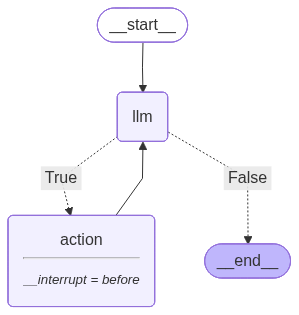

In [ ]:
from IPython.display import display, Image, Markdown

g = abot.graph.get_graph()

try:
    png_bytes = g.draw_mermaid_png()
    display(Image(png_bytes))
    with open("/content/agent_graph.png", "wb") as f:
        f.write(png_bytes)
except Exception as e1:
    try:
        png_bytes = g.draw_png()
        display(Image(png_bytes))
        with open("/content/agent_graph.png", "wb") as f:
            f.write(png_bytes)
    except Exception as e2:
        mermaid_src = g.draw_mermaid()
        display(Markdown(f"```mermaid\n{mermaid_src}\n```"))
        print("Rendered Mermaid source (install Mermaid or Graphviz to get an image).")


## References
1. [LangChain Academy](https://academy.langchain.com/courses/intro-to-langgraph) – curated courses & tutorials:    
  GitHub: <https://github.com/langchain-ai/langchain-academy.git>

2. [LangGraph Cookbook](https://github.com/abhishekmaroon5/langgraph-cookbook)

3. [LangChain Tutorials](https://python.langchain.com/docs/tutorials/)

4. [Interrupt](https://interrupt.langchain.com/) – the AI Agent Conference by LangChain  

5. [A Hands-On Guide to Building Intelligent Systems](https://docs.google.com/document/d/1rsaK53T3Lg5KoGwvf8ukOUvbELRtH-V0LnOIFDxBryE/preview?tab=t.0), Antonio Gulli

<!-- 6. [Prof. Ghassemi Lectures and Tutorials](https://www.youtube.com/@ghassemi), AI Agents lectures -->